# **ICESat-2 ATL11 Rate of Height change over Time (dhdt)**

This Jupyter notebook will cover the calculation of
Ice Height Changes (dh) over Time (dt) using Linear Regression.
Focusing on the Antarctic continent, for the ICESat-2 time period.
To save on computational resources, we'll run through a few preprocessing steps:

1. Select essential points
  - Subset to geographic region of interest (optional)
  - Drop points without at least 2 valid heights across all ICESat-2 cycles
2. Calculate height range (h_range)
  - Done for points which are valid and in geographic region of interest
  - Uses the `deepicedrain.nanptp` function
3. Calculate rate of height change over time (dhdt)
  - Done for points with `h_range > 0.25 metres`
  - Uses the `deepicedrain.nan_linregress` function

Adapted from https://github.com/suzanne64/ATL11/blob/master/plotting_scripts/AA_dhdt_map.ipynb

In [1]:
import os

import cudf  # comment out if no GPU
import dask
import geopandas as gpd
import holoviews as hv
import hvplot.cudf  # comment out if no GPU
import hvplot.pandas
import intake
import numpy as np
import pandas as pd
import panel as pn
import pygmt
import tqdm
import xarray as xr

import deepicedrain

In [2]:
client = dask.distributed.Client(n_workers=32, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:46793 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 32 Cores: 32 Memory: 201.22 GB


# Select essential points

In [3]:
# Xarray open_dataset preprocessor to add fields based on input filename.
add_path_to_ds = lambda ds: ds.assign_coords(
    coords=intake.source.utils.reverse_format(
        format_string="ATL11.001z123/ATL11_{referencegroundtrack:04d}1x_{}_{}_{}.zarr",
        resolved_string=ds.encoding["source"],
    )
)

# Load ATL11 data from Zarr
ds: xr.Dataset = xr.open_mfdataset(
    paths="ATL11.001z123/ATL11_*_003_01.zarr",
    chunks="auto",
    engine="zarr",
    combine="nested",
    concat_dim="ref_pt",
    parallel="True",
    preprocess=add_path_to_ds,
    backend_kwargs={"consolidated": True},
)

## Light pre-processing

- Reproject longitude/latitude to EPSG:3031 x/y
- Mask out low quality height data

In [4]:
# Calculate the EPSG:3031 x/y projection coordinates
ds["x"], ds["y"] = deepicedrain.lonlat_to_xy(
    longitude=ds.longitude, latitude=ds.latitude
)
# Set x, y, x_atc and y_atc as coords of the xarray.Dataset instead of lon/lat
ds: xr.Dataset = ds.set_coords(names=["x", "y", "x_atc", "y_atc"])
ds: xr.Dataset = ds.reset_coords(names=["longitude", "latitude"])

In [5]:
# Mask out low quality height data
ds["h_corr"]: xr.DataArray = ds.h_corr.where(cond=ds.fit_quality == 0)

## Trim out unnecessary values (optional)

There's ~220 million ATL11 points for the whole of Antarctica,
and not all of them will be needed depending on what you want to do.
To cut down on the number of data points the computer needs to work on,
we can:

- Subset to geographic region of interest
- Ensure there are at least 2 height values to calculate trend over time

In [6]:
# Antarctic bounding box locations with EPSG:3031 coordinates
regions = gpd.read_file(filename="deepicedrain/deepicedrain_regions.geojson")
regions: gpd.GeoDataFrame = regions.set_index(keys="placename")

In [7]:
# Subset dataset to geographic region of interest
placename: str = "antarctica"
region: deepicedrain.Region = deepicedrain.Region.from_gdf(gdf=regions.loc[placename])
# ds = region.subset(data=ds)

In [8]:
# We need at least 2 points to draw a trend line or compute differences
# So let's drop points with less than 2 valid values across all cycles
# Will take maybe 10-15 min to trim down ~220 million points to ~190 million
print(f"Originally {len(ds.ref_pt)} points")
# ds: xr.Dataset = ds.dropna(dim="ref_pt", thresh=2, subset=["h_corr"])
print(f"Trimmed to {len(ds.ref_pt)} points")

Originally 233577453 points
Trimmed to 233577453 points


### Optimize dataset for big calculations later

We'll rechunk the dataset to a reasonable chunk size,
and persist key dataset variables in memory so that the parallel
computations will be more efficient in later sections.

In [9]:
# ds["h_corr"] = ds.h_corr.unify_chunks()

In [10]:
# Persist the height and time data in distributed memory
ds["h_corr"] = ds.h_corr.persist()
ds["delta_time"] = ds.delta_time.persist()

### Retrieve some basic information for plots later

Simply getting the number of cycles and date range
to put into our plots later on

In [11]:
# Get number of ICESat-2 cycles used
num_cycles: int = len(ds.cycle_number)

In [12]:
# Get first and last dates to put into our plots
min_date, max_date = ("2018-10-14", "2020-09-30")
if min_date is None:
    min_delta_time = np.nanmin(ds.delta_time.isel(cycle_number=0).data).compute()
    min_utc_time = deepicedrain.deltatime_to_utctime(min_delta_time)
    min_date: str = np.datetime_as_string(arr=min_utc_time, unit="D")
if max_date is None:
    max_delta_time = np.nanmax(ds.delta_time.isel(cycle_number=-1).data).compute()
    max_utc_time = deepicedrain.deltatime_to_utctime(max_delta_time)
    max_date: str = np.datetime_as_string(arr=max_utc_time, unit="D")
print(f"Handling {num_cycles} ICESat-2 cycles from {min_date} to {max_date}")

Handling 9 ICESat-2 cycles from 2018-10-14 to 2020-09-30


# Calculate height range (h_range)

A simple way of finding active subglacial lakes is to see where
there has been a noticeably rapid change in elevation over
a short period of time such as 2-5 metres a year (or ~4x91-day ICESat-2 cycles).
'Range of height' is quick way to do this,
basically just doing maximum height minus minimum height.

In [13]:
# Calculate height range across cycles, parallelized using dask
ds["h_range"]: xr.DataArray = xr.apply_ufunc(
    deepicedrain.nanptp,  # min point to max point (range) that handles NaN values
    ds.h_corr,
    input_core_dims=[["cycle_number"]],
    dask="allowed",
    output_dtypes=[ds.h_corr.dtype],
    kwargs={"axis": 1},
)

In [14]:
# %%time
# Compute height range. Also include all height and time info
ds_ht: xr.Dataset = ds[["h_range", "h_corr", "delta_time"]].compute()

CPU times: user 9min 55s, sys: 2min 52s, total: 12min 47s
Wall time: 13min 9s


In [15]:
# Non-parallelized
# h_range = deepicedrain.nanptp(a=ds.h_corr[0:1], axis=1)
# Ensure no height range values which are zero (usually due to only 1 data point)
# assert len(dask.array.argwhere(dsh.h_range <= 0.0).compute()) == 0

In [16]:
# Save or Load height range data
# ds_ht.to_zarr(store=f"ATLXI/ds_hrange_time_{placename}.zarr", mode="w", consolidated=True)
ds_ht: xr.Dataset = xr.open_dataset(
    filename_or_obj=f"ATLXI/ds_hrange_time_{placename}.zarr",
    chunks={"cycle_number": 9},
    engine="zarr",
    backend_kwargs={"consolidated": True},
)
# ds: xr.Dataset = ds_ht  # shortcut for dhdt calculation later

In [17]:
df_hr: pd.DataFrame = ds_ht.h_range.to_dataframe()

In [18]:
print(df_hr.describe())

       referencegroundtrack             x         x_atc             y  \
count          2.335775e+08  2.335775e+08  2.335775e+08  2.335775e+08   
mean           7.193114e+02  2.247139e+05  3.012546e+07  6.021163e+04   
std            4.000892e+02  1.069767e+06  1.450550e+06  9.286819e+05   
min            1.000000e+00 -4.371480e+06  2.563873e+07 -2.551004e+06   
25%            3.690000e+02 -4.611121e+05  2.887693e+07 -5.909269e+05   
50%            7.430000e+02  1.747901e+05  3.013251e+07  3.711196e+04   
75%            1.074000e+03  9.954994e+05  3.138475e+07  7.076779e+05   
max            1.387000e+03  4.003066e+06  3.457507e+07  4.001492e+06   

              y_atc       h_range  
count  2.335775e+08  2.293047e+08  
mean   6.923369e+01  3.467586e-01  
std    2.747216e+03  3.433539e+00  
min   -4.311500e+03  0.000000e+00  
25%   -3.350000e+03  7.275391e-02  
50%    5.000000e-01  1.269531e-01  
75%    3.352500e+03  2.718506e-01  
max    4.350500e+03  1.420415e+04  


In [19]:
# Datashade our height values (vector points) onto a grid (raster image)
agg_grid: xr.DataArray = region.datashade(df=df_hr, z_dim="h_range")
print(agg_grid)

<xarray.DataArray (y: 1145, x: 1400)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 -2.698e+06 -2.694e+06 -2.69e+06 ... 2.794e+06 2.798e+06
  * y        (y) float64 -2.198e+06 -2.194e+06 -2.19e+06 ... 2.294e+06 2.298e+06


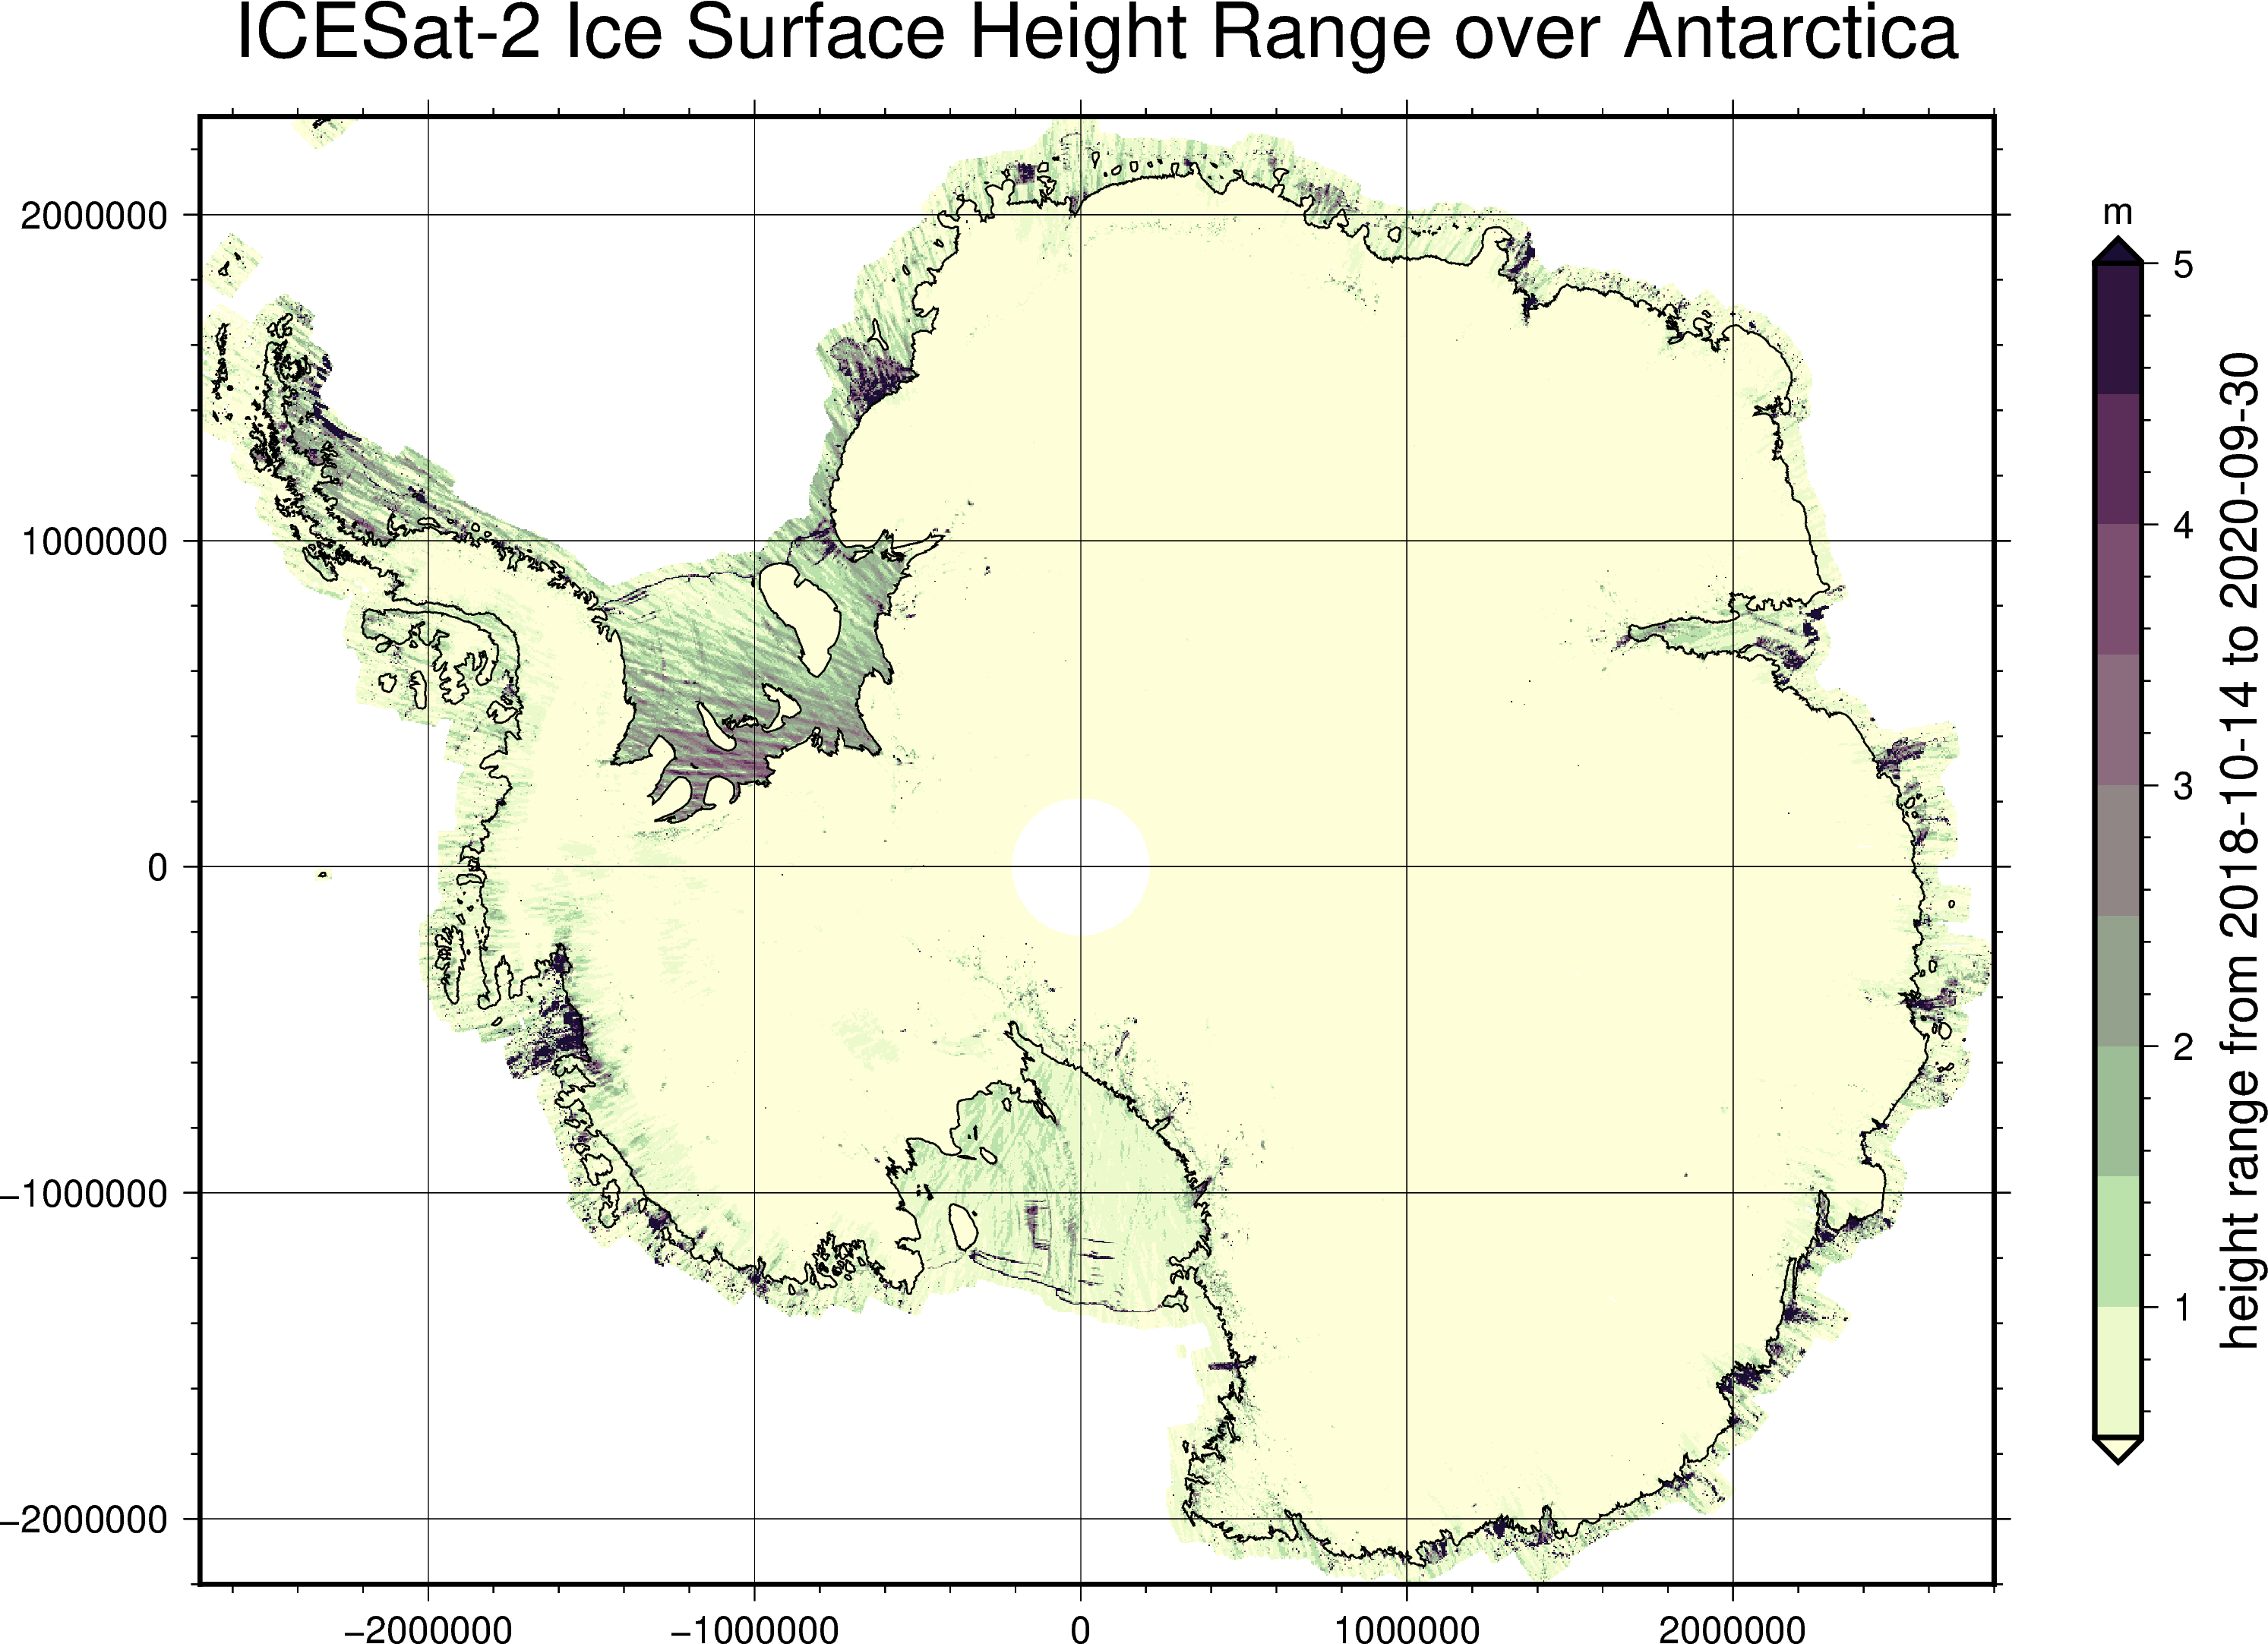

In [20]:
# Plot our map!
scale: int = region.scale
fig = pygmt.Figure()
pygmt.makecpt(cmap="tokyo", series=[0.5, 5, 0.5], reverse=True)
fig.grdimage(
    grid=agg_grid,
    region=region.bounds(),
    projection=f"x1:{scale}",
    frame=["afg", f'WSne+t"ICESat-2 Ice Surface Height Range over {region.name}"'],
    nan_transparent=True,
)
fig.colorbar(
    position="JCR+e",
    frame=["af", f'x+l"height range from {min_date} to {max_date}"', "y+lm"],
)
# for subglacial_lake in subglacial_lakes:
#     fig.plot(data=subglacial_lake, L=True, pen="thin")
fig.coast(
    region=region.bounds(),
    projection=f"s0/-90/-71/1:{scale}",
    area_thresh="+ag",
    resolution="i",
    shorelines="0.5p",
    verbose="q",
)
fig.savefig(f"figures/plot_atl11_hrange_{placename}_{min_date}_{max_date}.png")
fig.show(width=600)

# Calculate rate of height change over time (dhdt)

Performing linear regression in parallel.
Uses the [`scipy.stats.linregress`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) function,
parallelized with xarray's [`apply_ufunc`](http://xarray.pydata.org/en/v0.15.1/examples/apply_ufunc_vectorize_1d.html) method
on a Dask cluster.

In [21]:
# Take only the points where there is more than 0.25 metres of elevation change
# Trim down ~220 million points to ~36 million
# ds = ds.where(cond=ds.h_range > 0.25, drop=True)
print(f"Trimmed to {len(ds.ref_pt)} points")

Trimmed to 233577453 points


In [22]:
# Do linear regression on many datapoints, parallelized using dask
dhdt_params: xr.DataArray = xr.apply_ufunc(
    deepicedrain.nan_linregress,
    ds.delta_time.astype(np.uint64),  # x is time in nanoseconds
    ds.h_corr,  # y is height in metres
    input_core_dims=[["cycle_number"], ["cycle_number"]],
    output_core_dims=[["dhdt_parameters"]],
    # output_core_dims=[["slope_ns"], ["intercept"], ["r_value"], ["p_value"], ["std_err"]],
    dask="parallelized",
    vectorize=True,
    output_dtypes=[np.float32],
    output_sizes={"dhdt_parameters": 5},
    # output_sizes={"slope_ns":1, "intercept":1, "r_value":1, "p_value":1, "std_err":1}
)

In [23]:
# Construct an xarray.Dataset containing time, height, and dhdt variables
ds_dhdt: xr.Dataset = ds[["delta_time", "h_corr"]]
for var_name, dataarray in zip(
    ["slope", "intercept", "r_value", "p_value", "std_err"], dhdt_params.transpose()
):
    ds_dhdt[f"dhdt_{var_name}"]: xr.DataArray = dataarray

In [24]:
# Convert dhdt_slope units from metres per nanosecond to metres per year
# 1 year = 365.25 days x 24 hours x 60 min x 60 seconds x 1_000_000_000 nanoseconds
ds_dhdt["dhdt_slope"] = ds_dhdt["dhdt_slope"] * (365.25 * 24 * 60 * 60 * 1_000_000_000)

In [25]:
# %%time
# Compute rate of height change over time (dhdt). Also include all height and time info
ds_dhdt: xr.Dataset = ds_dhdt.compute()

CPU times: user 17min 26s, sys: 5min 25s, total: 22min 51s
Wall time: 53min 3s


In [26]:
# Do linear regression on single datapoint
# slope_ns, intercept, r_value, p_value, std_err = nan_linregress(
#     x=ds.delta_time[:1].data.astype(np.uint64), y=ds.h_corr[:1].data
# )
# print(slope_ns, intercept, r_value, p_value, std_err)

In [27]:
# Load or Save rate of height change over time (dhdt) data
# ds_dhdt.to_zarr(store=f"ATLXI/ds_dhdt_{placename}.zarr", mode="w", consolidated=True)
ds_dhdt: xr.Dataset = xr.open_dataset(
    filename_or_obj=f"ATLXI/ds_dhdt_{placename}.zarr",
    chunks="auto",
    engine="zarr",
    backend_kwargs={"consolidated": True},
)

In [28]:
df_slope: pd.DataFrame = ds_dhdt.dhdt_slope.to_dataframe()

In [29]:
# Datashade our height values (vector points) onto a grid (raster image)
agg_grid: xr.DataArray = region.datashade(df=df_slope, z_dim="dhdt_slope")
print(agg_grid)

<xarray.DataArray (y: 1145, x: 1400)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 -2.698e+06 -2.694e+06 -2.69e+06 ... 2.794e+06 2.798e+06
  * y        (y) float64 -2.198e+06 -2.194e+06 -2.19e+06 ... 2.294e+06 2.298e+06


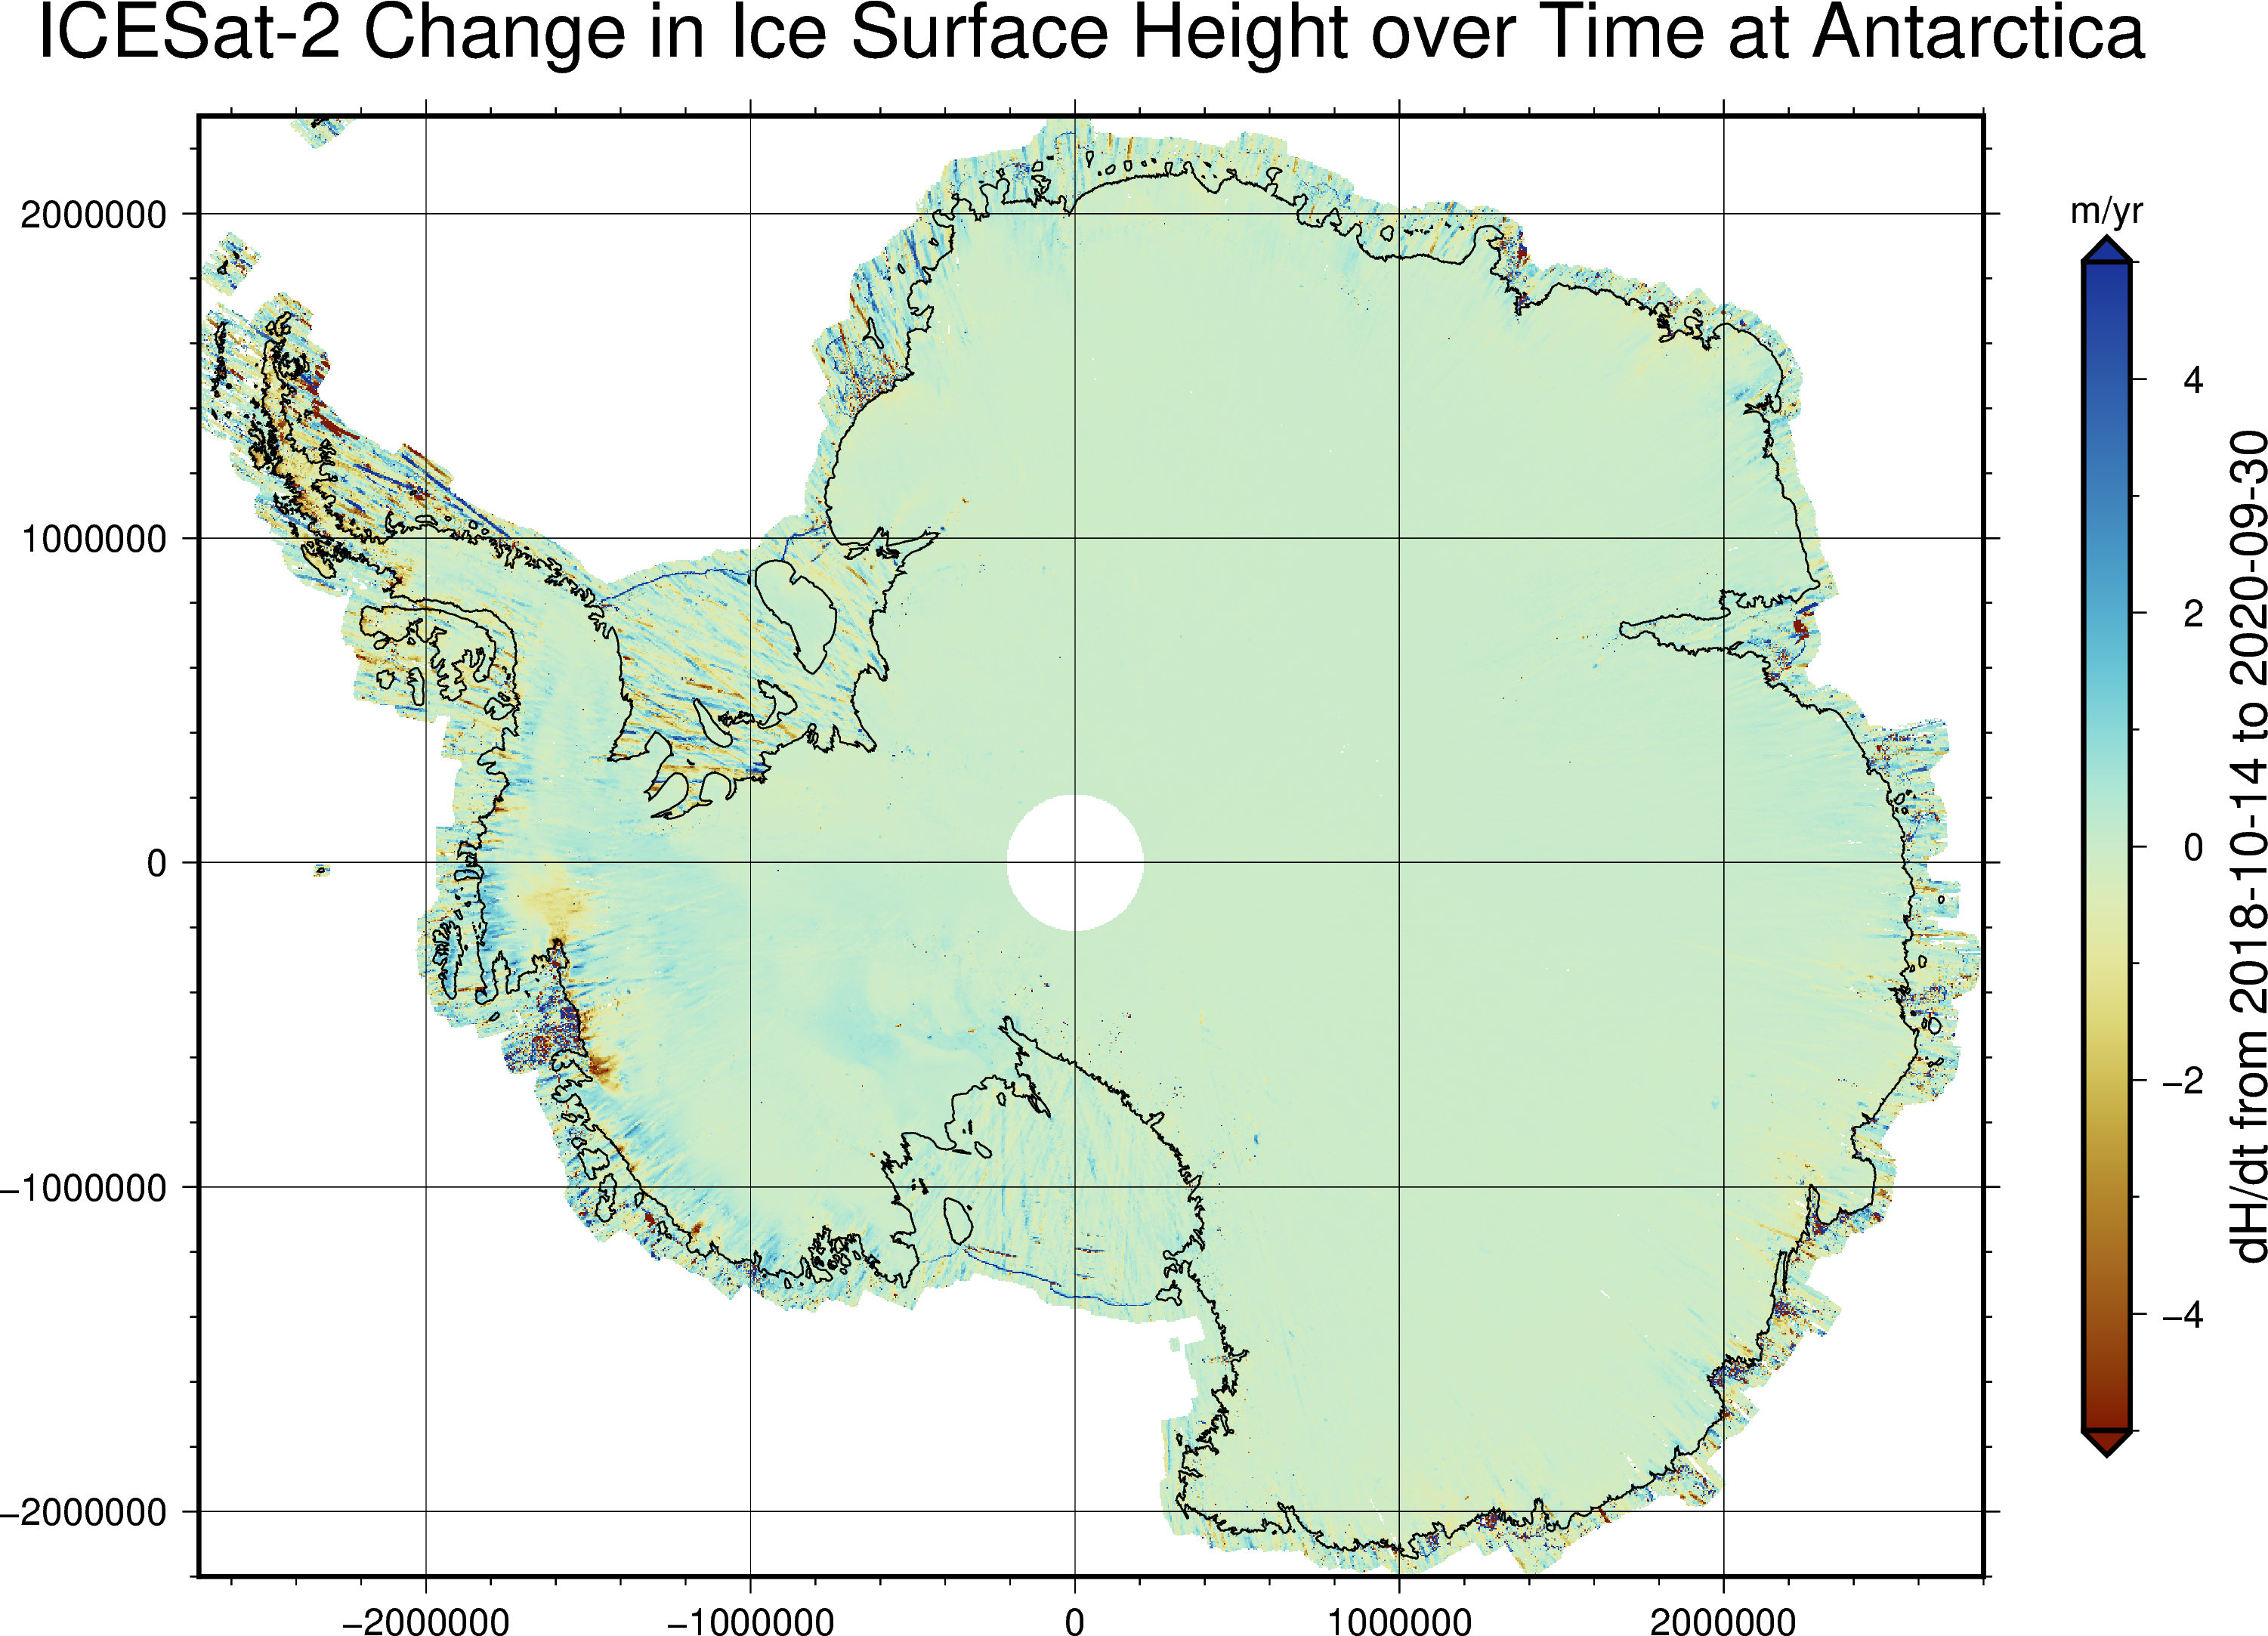

In [30]:
# Plot our map!
scale: int = region.scale
fig = pygmt.Figure()
pygmt.makecpt(cmap="roma", series=[-5, 5, 0.5], continuous=True)
fig.grdimage(
    grid=agg_grid,
    region=region.bounds(),
    projection=f"x1:{scale}",
    frame=[
        "afg",
        f'WSne+t"ICESat-2 Change in Ice Surface Height over Time at {region.name}"',
    ],
    nan_transparent=True,
)
fig.colorbar(
    position="JCR+e",
    frame=["af", f'x+l"dH/dt from {min_date} to {max_date}"', "y+lm/yr"],
)
# for subglacial_lake in subglacial_lakes:
#    fig.plot(data=subglacial_lake, L=True, pen="thinnest")
fig.coast(
    region=region.bounds(),
    projection=f"s0/-90/-71/1:{scale}",
    area_thresh="+ag",
    resolution="i",
    shorelines="0.5p",
    verbose="q",
)
fig.savefig(f"figures/plot_atl11_dhdt_{placename.lower()}_{min_date}_{max_date}.png")
fig.show(width=600)

# Along track plots of subglacial lake drainage/filling events

Let's take a closer look at one potential
subglacial lake filling event at Whillans Ice Stream.
We'll plot a cross-section view of
ice surface height changes over time,
along an ICESat-2 reference ground track.

In [31]:
# Save or load dhdt data from Parquet file
for placename in tqdm.tqdm(
    iterable=[
        "amundsen_sea_embayment",
        "siple_coast",
        "slessor_downstream",
        "whillans_downstream",
        "whillans_upstream",
        "Recovery",
    ]
):
    # TODO make the region detection code below better
    try:
        ice_boundaries: gpd.GeoDataFrame = (
            deepicedrain.catalog.measures_antarctic_boundaries.read()
        )
        drainage_basins: gpd.GeoDataFrame = ice_boundaries.query(expr="TYPE == 'GR'")

        drainage_basins: gpd.GeoDataFrame = drainage_basins.set_index(keys="NAME")
        region: deepicedrain.Region = deepicedrain.Region.from_gdf(
            gdf=drainage_basins.loc[placename], name="Recovery Basin"
        )
    except KeyError:
        region: deepicedrain.Region = deepicedrain.Region.from_gdf(
            gdf=regions.loc[placename]
        )

    if not os.path.exists(f"ATLXI/df_dhdt_{placename}.parquet"):
        # Subset dataset to geographic region of interest
        ds_subset: xr.Dataset = region.subset(data=ds_dhdt)
        # Rename delta_time (timedelta64) to utc_time (datetime64), because that's what it is
        ds_subset = ds_subset.rename(name_dict={"delta_time": "utc_time"})
        # Save to parquet format. If the dask workers get killed, reduce the number
        # of workers (e.g. 72 to 32) so that each worker will have more memory
        deepicedrain.ndarray_to_parquet(
            ndarray=ds_subset,
            parquetpath=f"ATLXI/df_dhdt_{placename.lower()}.parquet",
            variables=[
                "x",
                "x_atc",
                "y",
                "y_atc",
                "dhdt_slope",
                "referencegroundtrack",
                "h_corr",
                "utc_time"
            ],
            dropnacols=["dhdt_slope"],
            use_deprecated_int96_timestamps=True,
        )
# df_dhdt = pd.read_parquet(f"ATLXI/df_dhdt_{placename}.parquet")
df_dhdt: cudf.DataFrame = cudf.read_parquet(f"ATLXI/df_dhdt_{placename}.parquet")

In [ ]:
# Interactive holoviews scatter plot to find referencegroundtrack needed
# Tip: Hover over the points, and find those with high 'dhdt_slope' values
viewer = deepicedrain.IceSat2Explorer(name="ICESat-2 Explorer", placename=placename)
dashboard: pn.layout.Column = pn.Column(viewer.widgets, viewer.view)
# dashboard

In [ ]:
# Show dashboard in another browser tab
dashboard.show()

In [35]:
# Select a few Reference Ground tracks to look at
rgts: list = [135, 327, 388, 577, 1080, 1272]  # Whillans upstream
# rgts: list = [236, 501 , 562, 1181]  # whillans_downstream
for rgt in rgts:
    df_rgt: pd.DataFrame = df_dhdt.query(expr="referencegroundtrack == @rgt")
    df_rgt = deepicedrain.wide_to_long(
        df=df_rgt.to_pandas(), stubnames=["h_corr", "utc_time"], j="cycle_number"
    )
print(f"Looking at Reference Ground Tracks: {rgts}")

Looking at Reference Ground Tracks: [135, 327, 388, 577, 1080, 1272]


In [36]:
# Select one laser pair (out of three) based on y_atc field
# df = df_rgt.query(expr="y_atc < -100")  # left
df = df_rgt.query(expr="abs(y_atc) < 100")  # centre
# df = df_rgt.query(expr="y_atc > 100")  # right

In [ ]:
# Interactive scatter plot of height along one laser pair track, over time
df.hvplot.scatter(
    x="x_atc",
    y="h_corr",
    by="cycle_number",
    hover=True,
    hover_cols=["x", "y", "dhdt_slope"],
)

In [38]:
# Filter points to those with significant dhdt values > +/- 0.2 m/yr
# TODO Use Hausdorff Distance to get location of maximum change!!!
df = df.query(expr="abs(dhdt_slope) > 0.2 & h_corr < 300")

In [ ]:
# Plot 2D along track view of Ice Surface Height Changes over Time
fig = deepicedrain.plot_alongtrack(df=df, rgtpair=f"{rgt:04d}", regionname=region.name)
fig.savefig(fname=f"figures/alongtrack_{placename}_{rgt}.png")
fig.show()